# Clustering Analysis

This notebook contains the clustering analysis of the cuisine data. 

### Aim
To cluster cuisines in order to find which cuisines are similar based on the list of ingredients.


### Technical terms

We will proceed using term frequency inverse document frequency (tfidf) transformations to find which ingredients are most important to which cuisines. 

#### What is TfIdf? 

In order to determine which ingredients are important to a given cuisine, say 'Indian', the naive approach might be to consider the ingredients that appear the most in all the Indian and use this as a predictor. In this case, it turns out to be salt. However, it turns out that salt is the most common ingredient in 16 out of the 20 cuisines, and so even though it is the most common ingredient in Indian cuisine, it does not cary much information (similar to how articles like 'the' and 'a' might be the most common words in a document, but carry the least information).

the tf-idf of a term (ingredient) represents the importance of the term to a given class (cuisine). It is computed for a term (ingredient) $x$ as: <br>

<center> $\operatorname{tfidf}(x) = \operatorname{tf}(x) \cdot \operatorname{idf}(x)$

    
where $\operatorname{tf}(x)$ is the term frequency of $x$ and $\operatorname{idf}(x)$ is given by: <br>
    
<center> $\operatorname{idf}(x) = \ln (\frac{1+n}{1+dx}) + 1$



where $n$ is the number of classes (cuisines), $dx$ is the number of classes where $x$ appears.

## Method

### Step 1: TfIdf

First, we compute the tfidf of each term in each cuisine and store it in a matrix tfidf. To do this, we use the TfidfTransformer method from sklearn.feature_extraction.text package. This takes in a counts matrix C where C[i,j] represents the number of times term (ingredient) j appears in class (cuisine) i as an input, and outputs our tfidf matrix (where tfidf[i,j] represents the tfidf of term j in class i). 

### Step 2: PCA

We will then do a dimensionality reduction of the tfidf matrix to lower dimensions to get a matrix reduced_tfidf, where the first j columns will represent the j most important directions in the original tfidf matrix. Here, we will reduce to $n=2$ dimensions

### Step 3: KMeans 

With the different points in $\mathbb{R}^n$, or here $\mathbb{R}^2$, reduced_tfidf[i,:] for each cuisine i, we will use kmeans clustering to classify these into k clusters, each cluster representing cuisines that are similar

### Step 4: Hierarchical Clustering

Use agglomerative clustering to understand which cuisines are closest to one another within clusters. 

In [3]:
import numpy as np
import pandas as pd

In [4]:
train = pd.read_json("../data/train.json")
test = pd.read_json("../data/test.json")

## Step 0: Preprocessing

In [5]:
# Creating a function that gives the list of ingredients per cuisine. 
# We'll need to create a dictionary for this.
# This will make computing the counts_matrix for Step 1 easier

def dictionary(df):
    ingred_dict = {}
    cuisines_list = []
    ingredients_list = []
    
    for i in range(len(df)):
        
        curr_ing = df['ingredients'][i]
        curr_cuis = df['cuisine'][i]
        
        if curr_cuis not in ingred_dict.keys():
            cuisines_list.append(curr_cuis)
            ingred_dict[curr_cuis] = curr_ing
            
        else:
            temp = ingred_dict[curr_cuis]
            temp.extend(curr_ing)
            ingred_dict[curr_cuis] = temp
        
        ingredients_list.extend(curr_ing)
        
    unique_ing_list = list(set(ingredients_list))
        
    return ingred_dict, cuisines_list, unique_ing_list

In [6]:
ingred_dict, cuisines_list, unique_ing_list = dictionary(train)

## Step 1: Creating tfidf matrix

In [7]:
# Creating a count matrix for tf-idf transformation
# This is also a term frequency matrix

def CountsMat(ingred_dict, cuisines_list, unique_ing_list):
    
    counts_mat = np.zeros((len(cuisines_list), len(unique_ing_list)))
    i = 0
    
    for cuisine in cuisines_list:
        curr_ing_list = ingred_dict[cuisine]
        
        for ingredient in curr_ing_list:
            j = unique_ing_list.index(ingredient)
            counts_mat[i,j] +=1
        i+=1
    return counts_mat

In [8]:
counts_mat = CountsMat(ingred_dict, cuisines_list, unique_ing_list)

In [9]:
#Creating Tf-Idf matrix

from sklearn.feature_extraction.text import TfidfTransformer

To_tfidf = TfidfTransformer()
tfidf = To_tfidf.fit_transform(counts_mat)

tfidf = tfidf.toarray()

## Step 2: Using PCA to reduce the dimension of tfidf matrix

In [10]:
# Doing PCA to reduce the dimensions to two 

from sklearn.decomposition import PCA

n = 2 #Number of components

pca = PCA(n_components = n)
reduced_tfidf = pca.fit_transform(tfidf)

In [11]:
reduced_tfidf.shape

(20, 2)

## Step 3: Use KMeans clustering to classify similar cuisines

In [12]:
#Clustering by KMeans to classify similar cuisines based on reduced dimensions

from sklearn.cluster import KMeans

k = 4 #Number of clusters wanted

kmeans = KMeans(init='k-means++', n_clusters=k, n_init=20)
kmeans.fit(reduced_tfidf)
clusters = kmeans.predict(reduced_tfidf)

## Plotting data

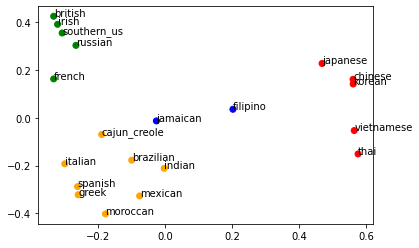

In [13]:
#Plotting Data

import matplotlib.pyplot as plt

colors_list = ['blue','orange','green', 'red', 'pink']
colors = []
labels = []
X = reduced_tfidf[:,0]
y = reduced_tfidf[:,1]

for i in range(len(cuisines_list)):
    colors.append(colors_list[clusters[i]])
    labels.append(cuisines_list[i])

    
plt.scatter(X, y, c = colors)

for i, label in enumerate(labels):
    plt.text(X[i], y[i],label)

plt.show()

## Step 4: Hierarchical Clustering

In [17]:
train = pd.read_csv("../data/ohe_train_recipes_v2.csv")
test = pd.read_csv("../data/ohe_test_recipes_v2.csv")
train_ingred_counts = train.drop(columns=['id']).groupby('cuisine').agg(sum)
tfidf = TfidfTransformer()
tfidf.fit(train_ingred_counts)
train_tfidf = pd.DataFrame(data=tfidf.transform(train_ingred_counts).toarray(),
                 index=train_ingred_counts.index,
                 columns=train_ingred_counts.columns)


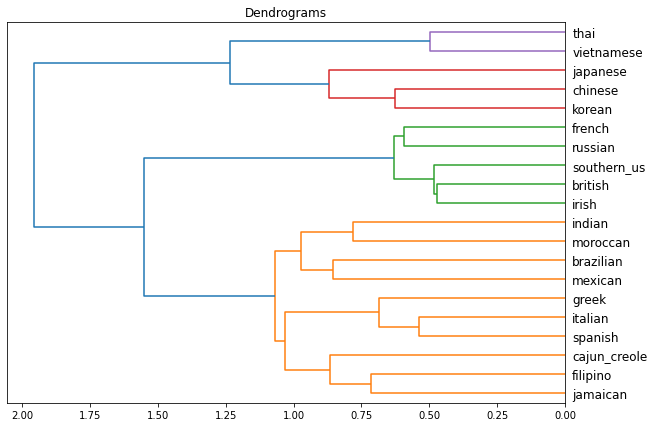

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = dendrogram(linkage(train_tfidf, method='ward'),
                      labels=train_tfidf.index.tolist(), 
                      truncate_mode=None,
                      orientation="left", 
                      color_threshold=1.2,
                      count_sort="descending")